<a href="https://colab.research.google.com/github/heghiw/credit-score/blob/main/misc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement **


Banks run into losses when a customer doesn't pay their loans on time. Because of this, every year, banks have losses in crores, and this also impacts the country's economic growth to a large extent. In this hackathon, we look at various attributes such as funded amount, location, loan, balance, etc., to predict if a person will be a loan defaulter or not.

imports

In [50]:
from pyspark.sql import SparkSession
import kagglehub
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.functions import col
from functools import reduce  # import reduce function
import matplotlib.pyplot as plt

data

In [51]:
path = kagglehub.dataset_download("ankitkalauni/bank-loan-defaulter-prediction-hackathon")



In [52]:
# create spark session
spark = SparkSession.builder \
    .appName("CreditScoreClassification") \
    .getOrCreate()

# read the dataset
df = spark.read.csv(path, header=True, inferSchema=True)

# show the first 5 rows
df.show(5)


+--------+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+-------------------+--------------+-------------------+------------+--------------------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+------------------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
|      ID|Loan Amount|Funded Amount|Funded Amount Investor|Term|Batch Enrolled|Interest Rate|Grade|Sub Grade|Employment Duration|Home Ownership|Verification Status|Payment Plan|          Loan Title|Debit to Income|Delinquency - two years|Inquires - six months|Open Account|Public Record|Revolving Balance|Revolving Utilities|Total Accounts|Initial List Status|Total Received Intere

# **Block 1 **
 **Data Cleaning and Exploration**

## 1.1
Duplicites, missing values

In [54]:
# get the second column name
second_column = df.columns[1]

# filter rows where the second column is null
null_second_column_rows = df.filter(col(second_column).isNull())

# show 5 rows where the second column is null
null_second_column_rows.show(5)



+---+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+-------------------+--------------+-------------------+------------+----------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+----------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
| ID|Loan Amount|Funded Amount|Funded Amount Investor|Term|Batch Enrolled|Interest Rate|Grade|Sub Grade|Employment Duration|Home Ownership|Verification Status|Payment Plan|Loan Title|Debit to Income|Delinquency - two years|Inquires - six months|Open Account|Public Record|Revolving Balance|Revolving Utilities|Total Accounts|Initial List Status|Total Received Interest|Total Received Late Fee|Recoveries|

In [55]:
id_zero_rows = df.filter(col("id") == 0)

# count the number of rows where 'id' is 0
num_id_zero_rows = id_zero_rows.count()

print(f"Number of rows where 'id' is 0: {num_id_zero_rows}")
# get the total number of rows
total_rows = df.count()

print(f"Total number of rows: {total_rows}")

# count the number of null values in each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts.show()

Number of rows where 'id' is 0: 28913
Total number of rows: 125289
+---+-----------+-------------+----------------------+-----+--------------+-------------+-----+---------+-------------------+--------------+-------------------+------------+----------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+----------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
| ID|Loan Amount|Funded Amount|Funded Amount Investor| Term|Batch Enrolled|Interest Rate|Grade|Sub Grade|Employment Duration|Home Ownership|Verification Status|Payment Plan|Loan Title|Debit to Income|Delinquency - two years|Inquires - six months|Open Account|Public Record|Revolving Balance|Revolving Utilities|Total Accounts|Initial Li

In [56]:
# filter out rows where 'id' is 0
df_filtered = df.filter(col("id") != 0)

df_filtered.show(5)


+--------+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+-------------------+--------------+-------------------+------------+--------------------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+------------------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
|      ID|Loan Amount|Funded Amount|Funded Amount Investor|Term|Batch Enrolled|Interest Rate|Grade|Sub Grade|Employment Duration|Home Ownership|Verification Status|Payment Plan|          Loan Title|Debit to Income|Delinquency - two years|Inquires - six months|Open Account|Public Record|Revolving Balance|Revolving Utilities|Total Accounts|Initial List Status|Total Received Intere

In [57]:
# count the number of duplicate rows
duplicates = df.subtract(df.dropDuplicates())

num_duplicates = duplicates.count()

print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


target leakage

## 1.2
Exploratory analysis, data types, distribution

In [58]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Loan Amount: integer (nullable = true)
 |-- Funded Amount: integer (nullable = true)
 |-- Funded Amount Investor: double (nullable = true)
 |-- Term: integer (nullable = true)
 |-- Batch Enrolled: string (nullable = true)
 |-- Interest Rate: double (nullable = true)
 |-- Grade: string (nullable = true)
 |-- Sub Grade: string (nullable = true)
 |-- Employment Duration: string (nullable = true)
 |-- Home Ownership: double (nullable = true)
 |-- Verification Status: string (nullable = true)
 |-- Payment Plan: string (nullable = true)
 |-- Loan Title: string (nullable = true)
 |-- Debit to Income: double (nullable = true)
 |-- Delinquency - two years: integer (nullable = true)
 |-- Inquires - six months: integer (nullable = true)
 |-- Open Account: integer (nullable = true)
 |-- Public Record: integer (nullable = true)
 |-- Revolving Balance: integer (nullable = true)
 |-- Revolving Utilities: double (nullable = true)
 |-- Total Accounts: integer

In [61]:
# get list of categorical columns (excluding 'ID')
categorical_columns = [col_name for col_name, dtype in df.dtypes if dtype == "string" and col_name != "ID"]

print("Unique values in categorical columns:")
for col_name in categorical_columns:
    # get unique values for the column
    unique_values = df.select(col_name).distinct()
    unique_count = unique_values.count()

    # print unique values only if there are less than 20 unique values
    if unique_count < 20:
        unique_list = unique_values.rdd.flatMap(lambda x: x).collect()  # collect unique values
        print(f"{col_name}: {unique_count} unique values")
        print(f"Values: {unique_list}")
    else:
        print(f"{col_name}: {unique_count} unique values (too many to list)")


Unique values in categorical columns:
Batch Enrolled: 42 unique values (too many to list)
Grade: 8 unique values
Values: ['F', 'E', 'B', 'D', 'C', 'A', 'G', None]
Sub Grade: 36 unique values (too many to list)
Employment Duration: 4 unique values
Values: ['OWN', 'RENT', 'MORTGAGE', None]
Verification Status: 4 unique values
Values: ['Verified', 'Source Verified', 'Not Verified', None]
Payment Plan: 2 unique values
Values: ['n', None]
Loan Title: 110 unique values (too many to list)
Initial List Status: 3 unique values
Values: ['f', 'w', None]
Application Type: 3 unique values
Values: ['JOINT', 'INDIVIDUAL', None]


In [62]:
# get basic statistics for numerical columns
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ["int", "double"]]
print("Basic statistics for numerical columns:")
df.select(numerical_columns).describe().show()

print("Basic statistics for categorical columns:")
for col_name in categorical_columns:
    # count occurrences of each unique value in the column
    value_counts = df.groupBy(col_name).count().orderBy('count', ascending=False)
    print(f"\nStatistics for {col_name}:")
    value_counts.show()

Basic statistics for numerical columns:
+-------+------------------+------------------+----------------------+------------------+------------------+-----------------+-----------------+-----------------------+---------------------+-----------------+-------------------+-----------------+-------------------+------------------+-----------------------+-----------------------+-----------------+-----------------------+----------------------------+-----------------+--------------------+-----------------------+---------------------+----------------------------+-------------------+
|summary|       Loan Amount|     Funded Amount|Funded Amount Investor|              Term|     Interest Rate|   Home Ownership|  Debit to Income|Delinquency - two years|Inquires - six months|     Open Account|      Public Record|Revolving Balance|Revolving Utilities|    Total Accounts|Total Received Interest|Total Received Late Fee|       Recoveries|Collection Recovery Fee|Collection 12 months Medical|    Last week Pay

In [63]:
# check data types of all columns
print("Data types of columns:")
for col_name, dtype in df.dtypes:
    print(f"{col_name}: {dtype}")


Data types of columns:
ID: string
Loan Amount: int
Funded Amount: int
Funded Amount Investor: double
Term: int
Batch Enrolled: string
Interest Rate: double
Grade: string
Sub Grade: string
Employment Duration: string
Home Ownership: double
Verification Status: string
Payment Plan: string
Loan Title: string
Debit to Income: double
Delinquency - two years: int
Inquires - six months: int
Open Account: int
Public Record: int
Revolving Balance: int
Revolving Utilities: double
Total Accounts: int
Initial List Status: string
Total Received Interest: double
Total Received Late Fee: double
Recoveries: double
Collection Recovery Fee: double
Collection 12 months Medical: int
Application Type: string
Last week Pay: int
Accounts Delinquent: int
Total Collection Amount: int
Total Current Balance: int
Total Revolving Credit Limit: int
Loan Status: int


graphs

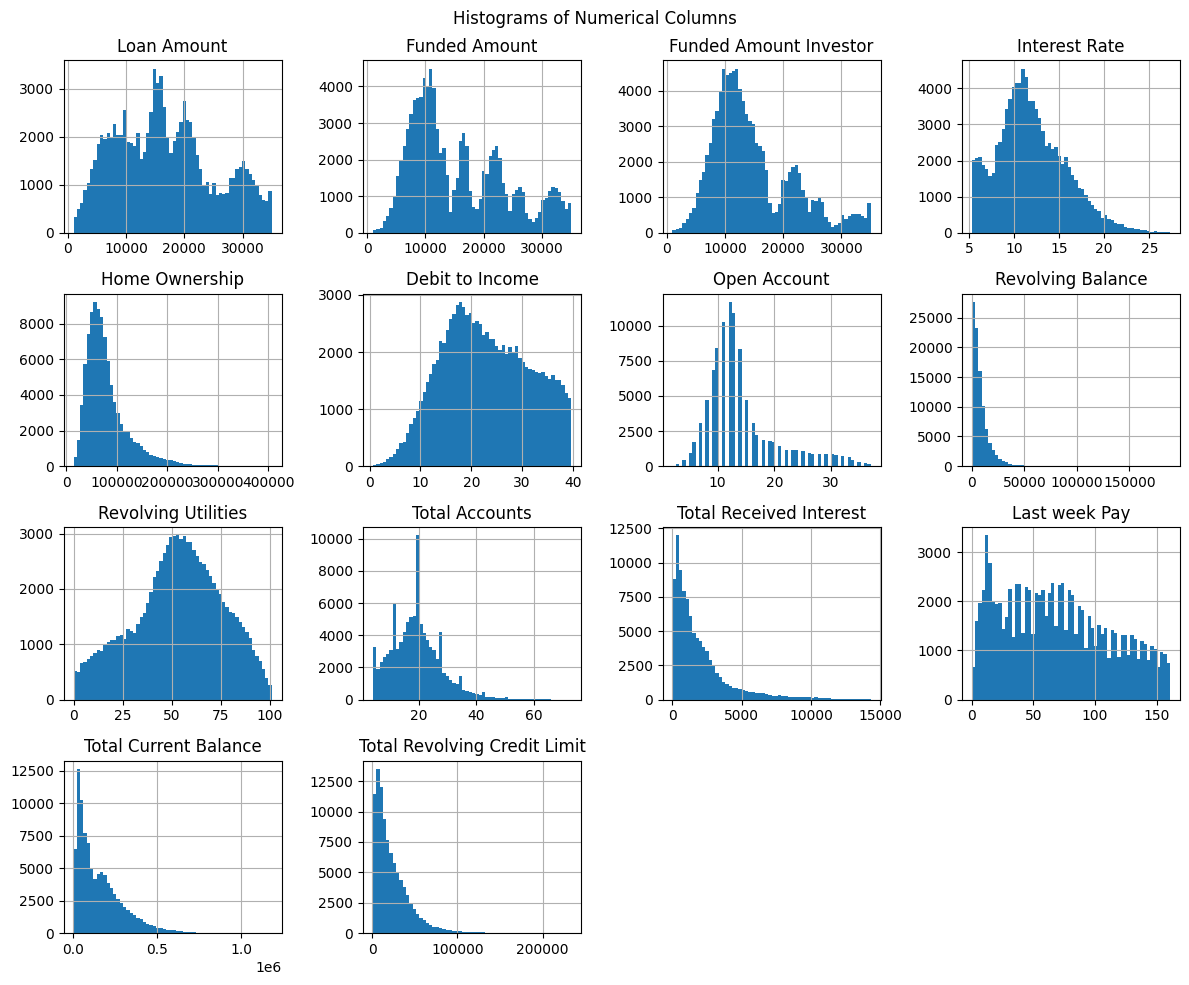

In [71]:
exclude_columns = [
    "Term", "Delinquency - two years", "Inquires - six months", "Public Record",
    "Total Received Late Fee", "Recoveries", "Collection Recovery Fee", "Collection 12 months Medical",
    "Accounts Delinquent", "Total Collection Amount", "Loan Status"
]

# get the numerical columns, excluding the specified columns
hist_data = [col_name for col_name, dtype in df_f.dtypes if dtype in ["int", "double"] and col_name not in exclude_columns]

# convert the selected numerical columns to pandas DataFrame
df_pandas = df_f.select(hist_data).toPandas()

# plot histograms for each numerical column
df_pandas.hist(bins=60, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Columns')
plt.tight_layout()
plt.show()

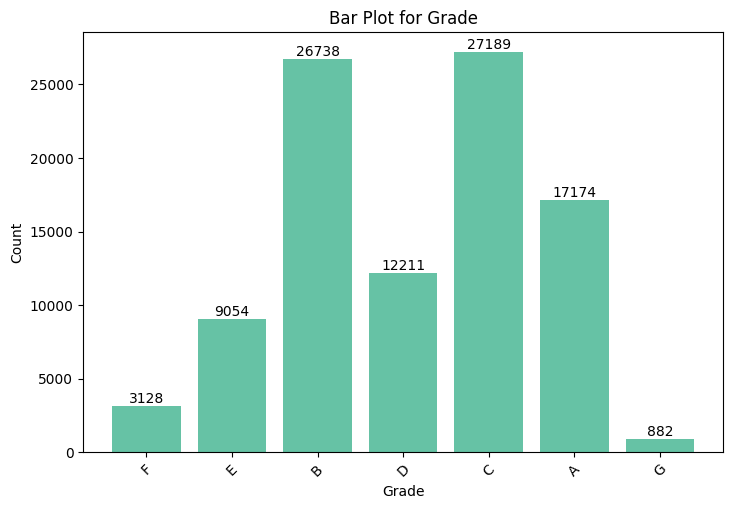

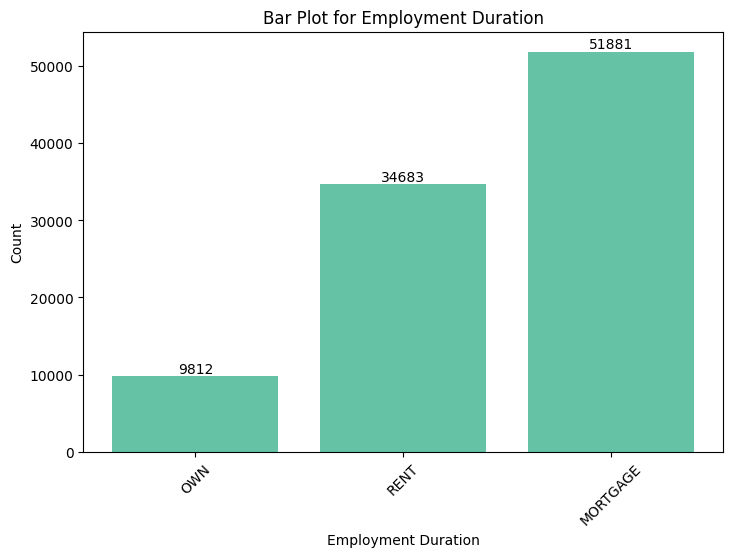

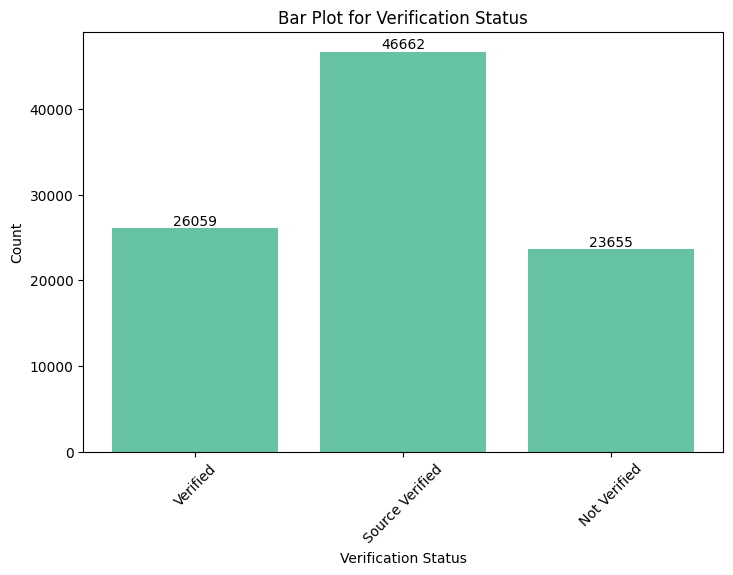

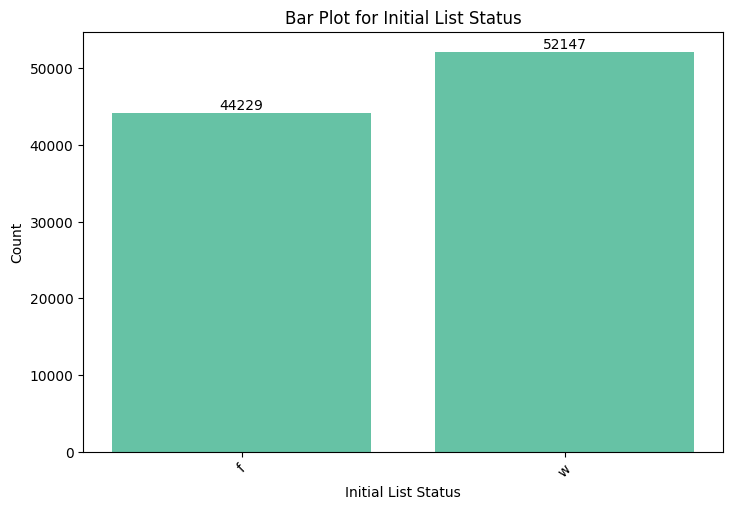

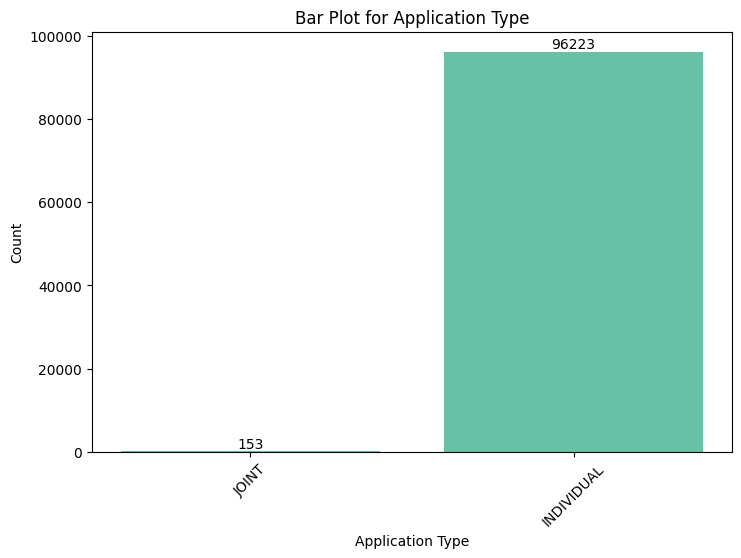

In [77]:
import seaborn as sns
sns.set_palette("Set2")

# loop through categorical columns and plot bar plots for those with less than 20 unique values and more than 1 unique value
for col_name in categorical_columns:
    # count unique values for each categorical column if >1 and <20
    unique_count = df_f.select(col_name).distinct().count()

    if unique_count > 1 and unique_count < 20:
        value_counts = df_f.groupBy(col_name).count().toPandas()

        # plot bar plot
        plt.figure(figsize=(8, 6))
        bars = plt.bar(value_counts[col_name], value_counts['count'])

        # annotate each bar with the count value on top
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

        plt.title(f"Bar Plot for {col_name}")
        plt.xlabel(col_name)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.subplots_adjust(bottom=0.2, left=0.15, right=0.95, top=0.9)
        plt.show()


## 1.3
Further cleaning the data [nulls were deleted during the previous steps]

In [79]:
df_f = df.drop("Payment Plan", "Loan Title") #only has 1 value, loan title has too many repeating values

In [80]:
df.show(5)

+--------+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+-------------------+--------------+-------------------+------------+--------------------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+------------------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
|      ID|Loan Amount|Funded Amount|Funded Amount Investor|Term|Batch Enrolled|Interest Rate|Grade|Sub Grade|Employment Duration|Home Ownership|Verification Status|Payment Plan|          Loan Title|Debit to Income|Delinquency - two years|Inquires - six months|Open Account|Public Record|Revolving Balance|Revolving Utilities|Total Accounts|Initial List Status|Total Received Intere